In [1]:
import numpy as np
import lalsimulation as lalsim
import lal
import matplotlib.pyplot as plt
import pycbc.conversions as cv
import pycbc.waveform
import pycbc.psd
import lalsimulation as lalsim
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)
%matplotlib inline
%env LAL_DATA_PATH=/work/lprudenzi/opt/lalsuite-extra/data/lalsimulation

env: LAL_DATA_PATH=/work/lprudenzi/opt/lalsuite-extra/data/lalsimulation


In [2]:
q_low = 1  
q_high = 10
Mc_low = 0.4
Mc_high = 5
lambda_low = 0
lambda_high = 5000
def lprior_q(q):
    if q < q_low or q > q_high:
        return -1e10 
    else:
        return np.log(1/(q_high - q_low))

def lprior_Mc(Mc):
    
    if Mc < Mc_low or Mc > Mc_high:
        return -1e10
    else:
        return np.log(1/(Mc_high - Mc_low))

def lprior_lambda(lambda_):
    
    if lambda_ < lambda_low or lambda_ > lambda_high:
        return -1e10
    else:
        return np.log(1/(lambda_high - lambda_low))
    

1.1742757165047846 1.0769230769230769
237305.44261499337


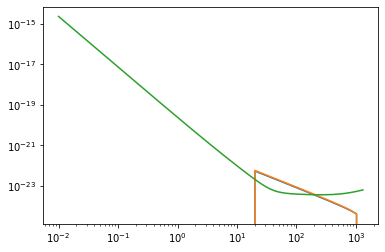

In [6]:
s1z = 0
s2z = 0
distance = 100 * 1e6 * lal.PC_SI
lambda1 = 400
lambda2 = 400
f_lower = 20
f_upper = 1024
df = 0.01
approx_fd = "SEOBNRv4T_Surrogate"

def htilde(par, approx_fd="SEOBNRv4T_Surrogate"):
    Mc = par[0]
    q = par[1]
    lambda1 = par[2]
    lambda2 = par[3]
    
    m1 = cv.mass1_from_mchirp_q(Mc,q)
    m2 = cv.mass2_from_mchirp_q(Mc,q)
    
    params_lal = lal.CreateDict()
    lalsim.SimInspiralWaveformParamsInsertTidalLambda1(params_lal, lambda1)
    lalsim.SimInspiralWaveformParamsInsertTidalLambda2(params_lal, lambda2)
    approx_lal = lalsim.GetApproximantFromString(approx_fd)
            
    hp_fd, hc_fd = lalsim.SimInspiralChooseFDWaveform(
                    m1*lal.MSUN_SI,
                    m2*lal.MSUN_SI,
                    0,
                    0, 
                    s1z,
                    0,
                    0,
                    s2z,
                    distance,
                    0,
                    0,
                    0,
                    0,
                    0,
                    df,
                    f_lower,
                    f_upper,
                    f_lower,
                    params_lal,
                    approx_lal)
            
    freq = np.arange(hp_fd.data.length)*df

    hp_fd = hp_fd.data.data
    hc_fd = hc_fd.data.data
    h = hp_fd+1j*hc_fd
    return freq, h

m1_inj = 1.4
m2_inj = 1.3
lambda1_inj = 400
lambda2_inj = 500

Mc_inj = cv.mchirp_from_mass1_mass2(m1_inj,m2_inj)
q_inj = cv.q_from_mass1_mass2(m1_inj,m2_inj)

print(Mc_inj, q_inj, lamba1_inj, lambda2_inj)

freq, h_inj = htilde([Mc_inj,q_inj,lambda1_inj, lambda2_inj])
freq, h_2 = htilde([Mc_inj+0.1,q_inj+0.1, lambda1_inj, lambda2_inj])

psd = []
for f in freq:
    psd.append(lalsim.SimNoisePSDaLIGOZeroDetHighPower(f))
asd = np.sqrt(psd)
print(np.nansum((np.abs(h_inj - h_2)**2) / psd))
plt.loglog(freq, np.abs(h_inj))
plt.loglog(freq, np.abs(h_2))
plt.loglog(freq, asd)
plt.show()

In [7]:
def inner_prod(h1_f,h2_f,psd):
    return (4*df) * np.real(np.nansum(np.conjugate(h1_f)*h2_f/psd))


snr2 = inner_prod(h_inj,h_inj,psd)
rho = np.sqrt(snr2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 66.64364145073478


<ipython-input-7-f8b4c902e753>:2: RuntimeWarning: invalid value encountered in true_divide
  return (4*df) * np.real(np.nansum(np.conjugate(h1_f)*h2_f/psd))


In [8]:
def llike(params):
    """
    Assumption: Known PSD otherwise need additional term
    """
    f, h_sampled = htilde(params)
    return(-0.5 * np.nansum((np.abs(h_inj - h_sampled)**2) / psd))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    Mc = params[0]
    q = params[1]
    lambda1 = params[2]
    lambda2 = params[3]

    if Mc < Mc_low or Mc > Mc_high or q < q_low or q > q_high or lambda1 < lambda_low or lambda1 > lambda_high or lambda2 < lambda_low or lambda2 > lambda_high:
        res = -np.inf
    else:
        res = llike(params) + lprior_Mc(Mc) + lprior_q(q)+lprior_lambda(lambda1)+lprior_lambda(lambda2)
    return res

In [9]:
from multiprocessing import Pool


In [ ]:
iterations = 100000
nwalkers = 16

pos = [Mc_inj,q_inj,lambda1_inj, lambda2_inj]
start = pos*(1+1e-2* np.random.randn(nwalkers, 4))
pool= Pool(32)

nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, pool=pool)
sampler.run_mcmc(start, iterations, progress=True)

In [36]:
flat_samples = sampler.get_chain(discard=25000, thin=1, flat=False)

In [37]:
org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten(),
                       flat_samples[:,:,3].flatten() #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))
print("inj = ", Mc_inj, q_inj, lambda1_inj, lambda2_inj)


number of samples =  (1200000, 4)
median =  [  1.17427512   1.07758847 410.52851843 486.64634523]
inj =  1.1742757165047846 1.0769230769230769 400 500


In [38]:
CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

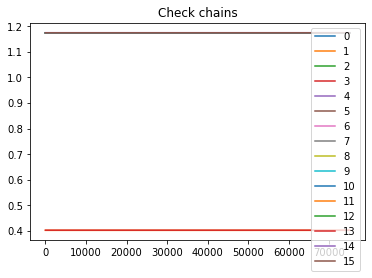

Gelman-Rubin statistic 178454.83537714687  for variable  0


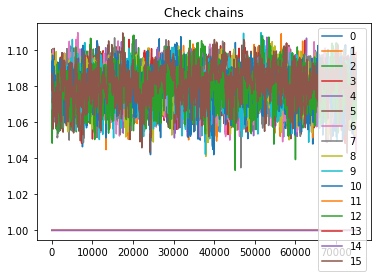

Gelman-Rubin statistic 4.4759150511962265  for variable  1


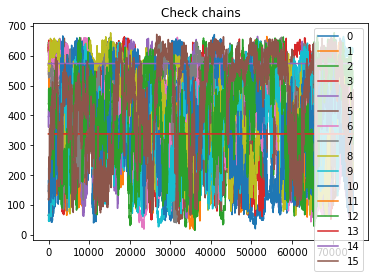

Gelman-Rubin statistic 1.084987390823404  for variable  2


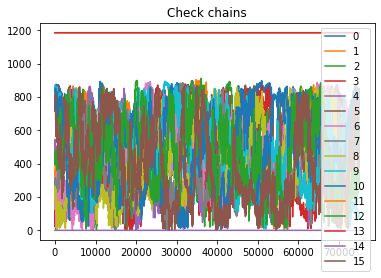

Gelman-Rubin statistic 1.7816984244272034  for variable  3


In [43]:
for variable in range(4):
    plt.figure()
    plt.title('Check chains')
    for i in range(nwalkers):
        plt.plot(flat_samples[:,i,variable], label=str(i))

    #plt.axhline(injection_params[variable] ,label='true',linestyle='--')
    plt.legend()
    plt.show()
    N = len(flat_samples[:,i,variable])

    W = 1/nwalkers * np.sum([ np.var(flat_samples[:,j,variable]) for j in range(nwalkers)])
    theta_bar_bar = np.mean([ np.mean(flat_samples[:,j,variable]) for j in range(nwalkers)])
    B = N/(nwalkers-1) *  np.sum([(np.mean(flat_samples[:,j,variable]) - theta_bar_bar)**2 for j in range(nwalkers)])
    Var = (1-1/N)*W + B/N
    R = np.sqrt(Var/W)
    print('Gelman-Rubin statistic', R, ' for variable ', variable)

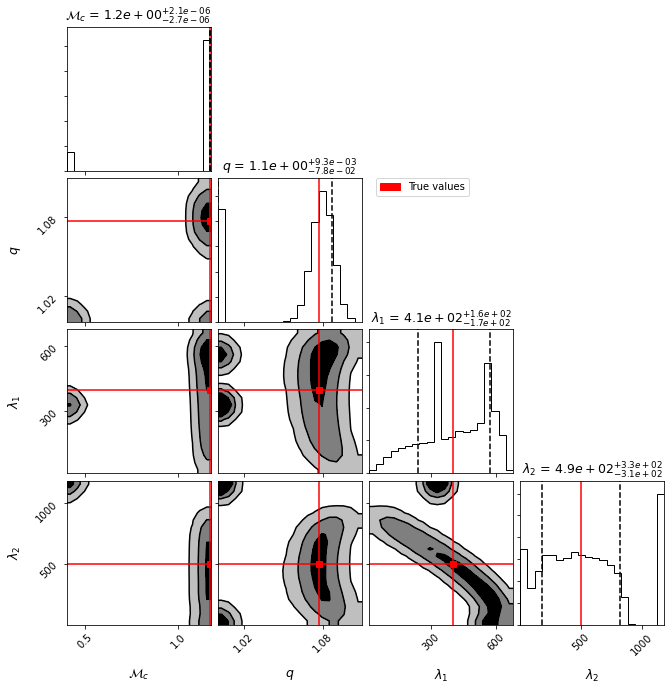

In [40]:
labels = [r'$\mathcal{M}_c$', r'$q$', r'$\lambda_1$', r'$\lambda_2$']
truths=[Mc_inj,q_inj, lambda1_inj, lambda2_inj]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()

In [27]:


org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten(),
                       flat_samples[:,:,2].flatten() #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (68000, 4)
median =  [4.00832531e-01 3.55349483e+00 1.42421115e+03 1.42421115e+03]


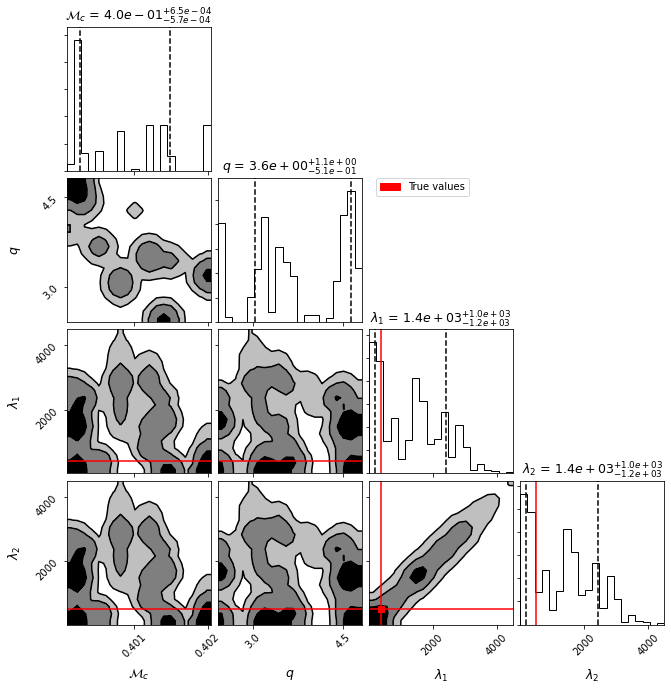

In [28]:
labels = [r'$\mathcal{M}_c$', r'$q$', r'$\lambda_1$', r'$\lambda_2$']
truths=[Mc_inj,q_inj, lambda1_inj, lambda2_inj]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()